### **LSTM (Long Short-Term Memory)**
- **Why it's a good fit**:
  - LSTMs are specifically designed for sequential data, like time series.
  - They handle long-term dependencies well, making them suitable for capturing trends and seasonality in stock data.
  - They mitigate the vanishing gradient problem better than vanilla RNNs, which is essential for time series data with long histories.

- **Why not GRU**:
  - GRUs (Gated Recurrent Units) are simpler and computationally faster but might not capture complex patterns in stock price data as effectively as LSTMs, particularly if the sequence length is long.

- **Why not Transformer-based models**:
  - Transformer-based models, while powerful, require larger datasets and more computational resources due to their attention mechanism.
  - For small datasets like the one we are using, Transformers can overfit and may not perform better than LSTMs or GRUs.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [3]:

df = pd.read_csv('apple_stock_data.csv', index_col=0)

# Parse the 'Date' column
# since the index is the Date so:
# df['Date'] = pd.to_datetime(df.index)
# df.set_index('Date', inplace=True)

# Keep only the 'Close' price for simplicity
# it is a univariate time series
data = df[['Close']].copy()
df.head()

,Open,High,Low,Close,Volume
1999-11-01,80.00,80.69,77.37,77.62,2487300.0
1999-11-02,78.00,81.69,77.31,80.25,3564600.0
1999-11-03,81.62,83.25,81.00,81.50,2932700.0
1999-11-04,82.06,85.37,80.62,83.62,3384700.0
1999-11-05,84.62,88.37,84.00,88.31,3721500.0


### Data Preprocessing

In [4]:
# Scale data between 0 and 1
# MinMaxScaler scales the data so that it is in the range of [0, 1].
# It is useful when the distribution of the data is not Gaussian or when you want to preserve the relationships between the variables' values
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Create training and testing datasets
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

# Create sequences
#  transform a univariate time series dataset into sequences of fixed length for supervised learning
def create_sequences(dataset, sequence_length=60):
    X, y = [], []
    for i in range(len(dataset) - sequence_length):
        X.append(dataset[i:i+sequence_length])
        y.append(dataset[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 60
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

print(f"Training shape: X={X_train.shape}, y={y_train.shape}")
print(f"Testing shape: X={X_test.shape}, y={y_test.shape}")


Training shape: X=(5011, 60, 1), y=(5011, 1)
Testing shape: X=(1208, 60, 1), y=(1208, 1)


### Why This Approach is Useful:
This sequence-generation method prepares the data for models like LSTMs and GRUs, which require sequential inputs to capture temporal patterns. By using fixed-length sequences and corresponding targets, the model learns to predict the next value based on historical data.

In [5]:
data_scaled.shape

(6339, 1)

### Build the model

In [6]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))

# Add output layer
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

### Model training

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - loss: 0.0142 - val_loss: 0.0013
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - loss: 0.0015 - val_loss: 9.8596e-04
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 96ms/step - loss: 0.0020 - val_loss: 8.5171e-04
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - loss: 0.0011 - val_loss: 9.8646e-04
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - loss: 0.0010 - val_loss: 7.8087e-04
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - loss: 9.1201e-04 - val_loss: 8.3431e-04
Epoch 9/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - loss: 8.7199e-04 - val_loss: 6.5825e-04
Epoch 10/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 0.0010 - val_loss: 6.7842e-04
Epoch 11/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - loss: 8.8883e-04 - val_loss

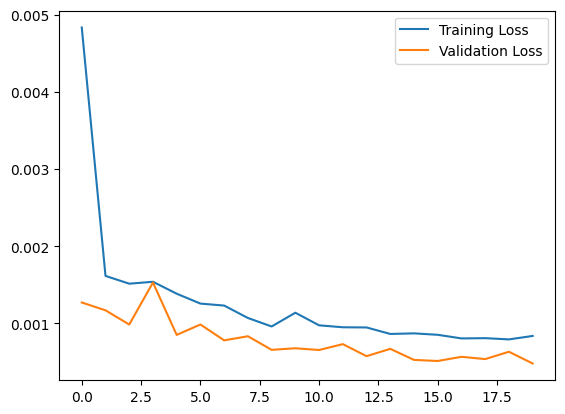

In [7]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step


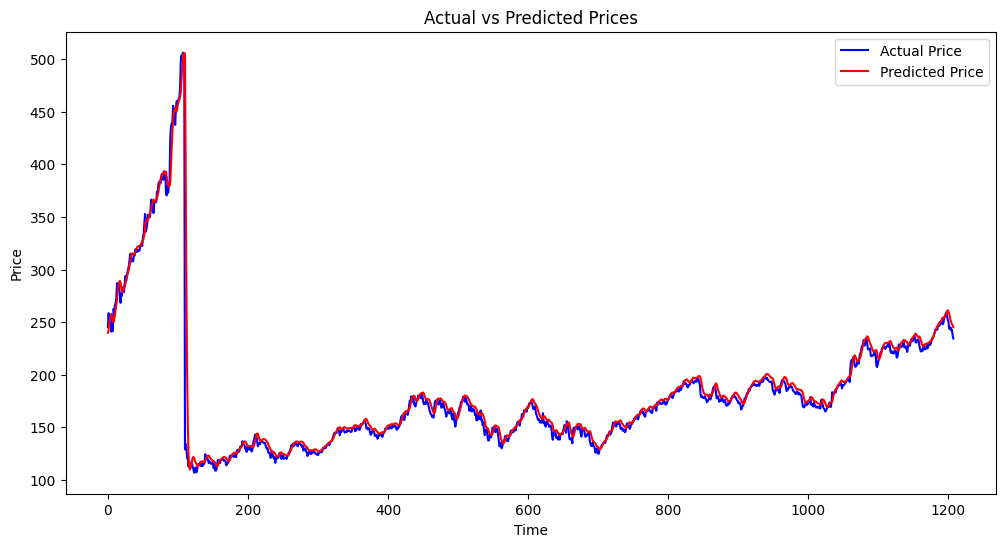

In [8]:
# Make predictions
y_pred = model.predict(X_test)

# Rescale back to original scale
y_test_rescaled = scaler.inverse_transform(y_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Price', color='blue')
plt.plot(y_pred_rescaled, label='Predicted Price', color='red')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


### Saving the model

In [11]:
model.save('lstm_stock_model.h5')
print("Model saved successfully!")

Model saved successfully!
